In [1]:
import os
import sys
import yaml
import numpy as np
from pathlib import Path
from scipy import stats
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction/'
omitir = ''

def search_subfolders(path:str):
    '''Funcion para agregar rutas al path de ejecucion'''
    folder = []
    for root, dirs, _ in os.walk(path, topdown=False):
        for name in dirs:
            if name == omitir:
                print(f"[INFO] carpeta omitida: {name}")
            else:
                folder.append(os.path.join(root, name))
    return folder


for i in search_subfolders(path_folder):
    sys.path.insert(0, i)

from class_load import LoadFiles
from factory_data import SQLDataSourceFactory, get_data
from factory_models import ModelContext  # , Modelos, Parameters_model
from factory_prepare_data import (DataCleaner, DataModel,
                                          MeanImputation, OutliersToIQRMean)
from features_fix_data import PrepareData

import pandas as pd
from DP_model import Modelos,Parameters_model

attempted relative import with no known parent package


In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm
from darts.metrics import mape, r2_score, mse,mase,rmse,rho_risk, smape
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [3]:

# path_folder = os.path.dirname(__file__)abs
path_folder = '/home/bdebian/Documents/Projects/Stoke_prediccition/app_prediction'
folder_model = Path(path_folder).joinpath('scr/data/save_models')

handler_load = LoadFiles()
# ruta_actual = os.path.dirname(__file__)
ruta_actual = path_folder
# #=================================================================
# #             Cargar datos de la fuente de datos 
# #=================================================================
CONFIG_FILE = Path(ruta_actual).joinpath('src/data/config/config.yaml')
with open(CONFIG_FILE, 'r', encoding='utf-8') as file:
    parameters = yaml.safe_load(file)

print("Probando el estacion de datos de sql")
data = get_data(SQLDataSourceFactory(**parameters))


Probando el estacion de datos de sql


In [4]:
#=================================================================
#             Limpieza de datos
#=================================================================

new_types = []
base = {
    'date':np.datetime64,
    'integer': int,
    'float': float,
    'string': 'object',
}

for dtypo in parameters['type_data'].values():
    # print(dtypo)
    new_types.append(base[dtypo])

#metodo para transformar los tipo de datos
strategy = {
    int:np.mean,
    float:np.mean,
    object:stats.mode
}

#Estrategias para imputar los datos faltantes de NA
replace = {
    int:lambda x: int(float(x.replace(',',''))),
    float:lambda x: float(x.replace(',',''))
}


#Imputacion de los datos
imputation = MeanImputation(
                            replace_dtypes=new_types,
                            strategy_imputation=strategy,
                            preprocess_function=replace,
                            **parameters
                            )
#Remocion de outliners y seleccion de columnas
outliners = OutliersToIQRMean(**parameters)

#Preparacion de los dato para el modelos escalizado y filtrado
data_for_model = DataModel(**parameters)

#Patron de diseno de seleecion de estrategia
cleaner = DataCleaner(imputation)
data_imputation = cleaner.clean(data)

#Cambio de estrategia para remover outliners
cleaner.strategy = outliners
data_filled = cleaner.clean(data_imputation.dataframe)

#Cambio de estrategia para preparar los datos para modelo
cleaner.strategy = data_for_model
data_ready,scaler_data = cleaner.clean(data_filled)


In [5]:
#=================================================================
#            Cargar modelo
#=================================================================
MODE_USED = 'NBeatsModel'
modelo = ModelContext(model_name = MODE_USED,
                      data=data_ready,
                      split=83,
                      **parameters)

#Rutas de los parametros para predicciones
model_train = modelo.save_path.joinpath('model').with_suffix('.pt').as_posix()
scaler = modelo.save_path.joinpath('scaler').with_suffix('.pkl').as_posix()
last_pred =  modelo.save_path.joinpath('previus').with_suffix('.json').as_posix()
parameters_modelo = modelo.save_path.joinpath('parametros').with_suffix('.json').as_posix()


#Cargar escaler
scaler = handler_load.load_scaler(scaler)

# #Cargar el ultimo punto de predicciones
# last_prediction = handler_load.json_to_dict(last_pred)[0]
# past, future = modelo.tunne_parameter.data.split_after(
#     pd.Timestamp(last_prediction['last_date_pred']))
# model_used_parameters = handler_load.json_to_dict(parameters_modelo)[0]

#Cargar modelo para hacer las predicciones
MODE_USED = 'NBeatsModel'
IntModel = Modelos[MODE_USED]
model_trained = IntModel.load(model_train)


# pred_series = model_trained.predict(
#     series=past,
#     n = parameters['forecast_val']
# )


pred_series = modelo.predict(
        model=model_trained,
        data=modelo.tunne_parameter.data,
        horizont=parameters['forecast_val']
        )
#Invertir predicciones
pred_scale = scaler.inverse_transform(pred_series)

Modelo importado NBeatsModel


/home/bdebian/.virtualenvs/app_prediction/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

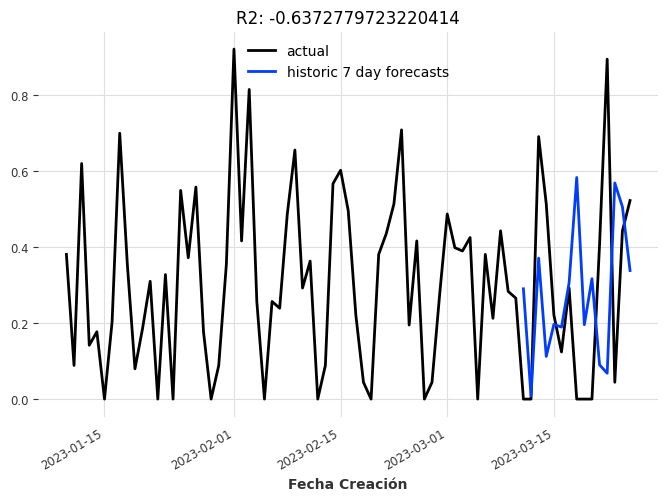

In [6]:
display_forecast(pred_series, modelo.tunne_parameter.data, "7 day", start_date=modelo.tunne_parameter.split_value)

In [70]:
data_frame_predicciones = pred_scale.pd_dataframe()

# data_frame_predicciones['varianza']abs
data_frame_predicciones['Varianza'] = data_frame_predicciones['Cant Pedido UMV'].pct_change() * 100

data_frame_predicciones.reset_index(inplace=True)

In [74]:
filter = []
for filter_list in parameters['filter_data']:
    if 'feature' in filter_list:
        filter.append(parameters['filter_data'][filter_list])

for adding_data  in filter:
    data_frame_predicciones[str(adding_data)] = adding_data

new_names = list(parameters['query_template_write']['columns'].values())
rename= {x:y for x,y in zip(list(data_frame_predicciones.columns),new_names)}

data_frame_predicciones.rename(columns=rename,inplace=True)

In [75]:
data_frame_predicciones

component,Fecha,predicion,varianza,Material (Cod),Solicitate (Cod)
0,2023-03-11,327.784822,NaN,10011308,4177452
1,2023-03-12,9.715497,-97.036014,10011308,4177452
2,2023-03-13,418.827413,4210.921304,10011308,4177452
3,2023-03-14,126.734135,-69.740726,10011308,4177452
4,2023-03-15,221.939540,75.122148,10011308,4177452
5,2023-03-16,213.895659,-3.624357,10011308,4177452
6,2023-03-17,345.756961,61.647488,10011308,4177452
7,2023-03-18,658.486616,90.447826,10011308,4177452
8,2023-03-19,220.941006,-66.447153,10011308,4177452
9,2023-03-20,357.808434,61.947499,10011308,4177452


In [8]:
connection = parameters['connection_data_source']

In [9]:
# create_table(SQLDataSourceFactory(**parameters))

In [10]:
from features_postgres import HandleDBpsql

In [11]:
data_source = HandleDBpsql()

In [13]:
conver_postgrest = {
    'date': 'DATE',
    'integer': 'NUMERIC(15,3)',
    'float': 'DECIMAL(12,3)',
    'string': 'VARCHAR(50)',
}

convert_value = {}
for key_,val_ in parameters['type_data_out'].items():
    convert_value[key_] = conver_postgrest[val_]

# Aquí es donde construirás las declaraciones para las columnas.
column_declarations = []

# Obtén los nombres de las columnas y los tipos de datos del yaml.
column_names = parameters['query_template_write']['columns']
data_types = parameters['type_data_out']

# Ahora, crea las declaraciones para las columnas usando los nombres y los tipos de datos.
for i in range(len(column_names)):
    column_name = column_names[str(i)]
    data_type = data_types['column' + str(i)]
    postgrest_type = conver_postgrest[data_type]
    column_declarations.append(f'"{column_name}" {postgrest_type}')

column_declarations_str = ",\n".join(column_declarations)

fix_data_dict = parameters['query_template_write'].copy()
fix_data_dict['columns'] = column_declarations_str
# parametro.query_template_write['table'] = self.parametro.filter_data['filter_1_feature']

In [14]:
query = data_source.prepare_query_replace_value(
    sql_file=parameters['query']['query_create'],
    data_replace=fix_data_dict)

In [15]:
query

'CREATE TABLE prediction (     index serial PRIMARY KEY,     "Fecha" DATE,\n"predicion" DECIMAL(12,3),\n"varianza" DECIMAL(12,3),\n"Material (Cod)" VARCHAR(50),\n"Solicitate (Cod)" VARCHAR(50) ) '

In [ ]:
fix_dict_query = data_source.fix_dict_query(
    parameters['query_template_write']['table'],
    list(parameters['query_template_write']['columns'].values()),
    parameters['query_template_write']['order'],
    parameters['query_template_write']['where']
)

query = data_source.prepare_query_replace_value(
    sql_file=parameters['query']['query_write'],
    data_replace=fix_dict_query)

data_source.insert_data_from_dataframe(
    connection_parameters=parameters['connection_data_source'],
    dataframe=data_frame_predicciones,
    query=query
)

In [27]:
params = data_source.get_config_file(parameters['connection_data_source'])


In [30]:
import psycopg2

In [31]:
conn = psycopg2.connect(**params)

In [32]:

# create a new cursor
cur = conn.cursor()

In [33]:
for data_row in data_frame_predicciones.values:
    print(data_row)

[Timestamp('2023-03-11 00:00:00') 327.7848216374308 nan]
[Timestamp('2023-03-12 00:00:00') 9.715496613654604 -97.03601388095966]
[Timestamp('2023-03-13 00:00:00') 418.8274132698008 4210.921303612638]
[Timestamp('2023-03-14 00:00:00') 126.73413520017559 -69.74072584916121]
[Timestamp('2023-03-15 00:00:00') 221.93953965018522 75.12214787249974]
[Timestamp('2023-03-16 00:00:00') 213.8956590914339 -3.624356692561337]
[Timestamp('2023-03-17 00:00:00') 345.75696082297554 61.64748844911103]
[Timestamp('2023-03-18 00:00:00') 658.4866162591761 90.44782632628339]
[Timestamp('2023-03-19 00:00:00') 220.94100553244758 -66.44715320296099]
[Timestamp('2023-03-20 00:00:00') 357.80843366471566 61.94749942521087]
[Timestamp('2023-03-21 00:00:00') 101.84900650751213 -71.53532535151206]
[Timestamp('2023-03-22 00:00:00') 76.74359799907693 -24.64963515042583]
[Timestamp('2023-03-23 00:00:00') 642.2150611669889 736.8320979356655]
[Timestamp('2023-03-24 00:00:00') 571.2822339383885 -11.045027050550049]
[Times

In [ ]:


for data_row in dataframe.values:
    # execute the INSERT statement
    cur.execute(query, (data_row))
    print('insertando')
# commit the changes to the database
conn.commit()
# close communication with the database
cur.close()